In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu 
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest 
import os





In [ ]:

# --- Stage 0: Preparation ---
print("--- Stage 0: Preparation ---")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

base_path = 'C:/Snapp/git/azki'  #  PATH
output_dir = os.path.join(base_path, "ab_test_analysis_output_v3") 
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Output directory created: {output_dir}")
else:
    print(f"Output directory already exists: {output_dir}")
print("Preparation complete.\n")

# --- Stage 1: Loading and Initial Data Cleaning & Verification ---
print("--- Stage 1: Loading and Initial Data Cleaning & Verification ---")
csv_file_path = os.path.join(base_path, "data.csv")

# ALWAYS LOAD THE DATAFRAME FRESHLY
try:
    df_original = pd.read_csv(csv_file_path) # Load into a new variable first
    df = df_original.copy() # Work on a copy
    print(f"Dataset loaded successfully from: {csv_file_path}")
except FileNotFoundError:
    print(f"Dataset file '{csv_file_path}' not found. Please check the path.")
    exit()

print("\nInitial dataset information (df.info()):")
df.info()

print("\nFirst 5 rows of the raw dataset (df.head()):")
print(df.head())

print("\nInitial check for missing values (df.isnull().sum()):")
print(df.isnull().sum())

# 1. Parse the 'group' column (Only if it exists)
if 'group' in df.columns:
    print("\n'group' column found. Parsing...")
    def parse_group_json(json_str):
        try:
            data = json.loads(json_str)
            return pd.Series([data['value']['group'], data['value']['operation_cost']])
        except (json.JSONDecodeError, TypeError, KeyError):
            return pd.Series([None, None])

    df[['group_letter', 'operation_cost']] = df['group'].apply(parse_group_json)
    df.drop('group', axis=1, inplace=True)
    print("'group' column parsed into 'group_letter' and 'operation_cost'.")
else:
    print("\n'group' column not found. Assuming it was already parsed in a previous run.")
    # Check if 'group_letter' and 'operation_cost' already exist
    if not ('group_letter' in df.columns and 'operation_cost' in df.columns):
        print("ERROR: 'group' column is missing AND 'group_letter'/'operation_cost' are also missing. Cannot proceed.")
        exit()
    else:
        print("'group_letter' and 'operation_cost' columns already exist.")


# --- !!! IMPORTANT VERIFICATION STEP !!! ---
print("\n--- VERIFICATION OF GROUP ASSIGNMENT AND OPERATION COSTS ---")
# Ensure group_letter and operation_cost are not NaN before groupby if they were just created
# (This shouldn't be an issue if parse_group_json handles errors by returning None,
#  but good to be aware of. If they contain NaNs, groupby might behave unexpectedly or error)
if df['group_letter'].isnull().any() or df['operation_cost'].isnull().any():
    print("Warning: NaN values found in 'group_letter' or 'operation_cost' after parsing.")
    print(df[df['group_letter'].isnull() | df['operation_cost'].isnull()])

group_cost_distribution = df.groupby(['group_letter', 'operation_cost'], dropna=False).size().reset_index(name='count')
print(group_cost_distribution)
# --- !!! END OF IMPORTANT VERIFICATION STEP !!! ---

# 2. Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])
print("\n'date' column converted to datetime type.")

# 3. Convert 'price' column to float and handle invalid entries
df['price'] = pd.to_numeric(df['price'], errors='coerce')
print("\n'price' column converted to numeric (float) type.")
initial_rows = len(df)
df.dropna(subset=['price'], inplace=True) # Remove rows with NaN price
rows_after_price_dropna = len(df)
if initial_rows > rows_after_price_dropna:
    print(f"{initial_rows - rows_after_price_dropna} rows with invalid prices were removed.")
else:
    print("No rows with invalid prices found or removed.")


# 4. Handle missing values in 'user_device' and 'renewal_status'
df['user_device'].fillna('unknown', inplace=True)
df['renewal_status'].fillna('unknown', inplace=True)
print("\nMissing values in 'user_device' and 'renewal_status' filled with 'unknown'.")

print("\nMissing values after all initial cleaning (df.isnull().sum()):")
print(df.isnull().sum())

print("\nDataset information after initial cleaning (df.info()):")
df.info()

print("\nFirst 5 rows of the cleaned dataset (df.head()):")
print(df.head())
print("\nLast 5 rows of the cleaned dataset (df.tail()):")
print(df.tail())
print("\nUnique values in 'group_letter':", df['group_letter'].unique())
print("Unique values in 'operation_cost':", df['operation_cost'].unique())
print("-" * 50)

--- Stage 0: Preparation ---
Output directory created: /home/shared/Atefeh/tn_refactor_log/az/ab_test_analysis_output_v3


Preparation complete.

--- Stage 1: Loading and Initial Data Cleaning & Verification ---
Dataset file '/home/shared/Atefeh/tn_refactor_log/az/data.csv' not found. Please check the path.

Initial dataset information (df.info()):


NameError: name 'df' is not defined

: 


--- Stage 2: Exploratory Data Analysis (EDA) ---

Descriptive statistics for numerical columns:
       insurance_company_id         price                           date  \
count            5000.00000  5.000000e+03                           5000   
mean               42.19200  6.174227e+06  2022-10-08 16:24:02.416400128   
min                15.00000  2.690800e+05            2018-10-21 16:11:41   
25%                27.00000  4.537500e+06  2022-09-25 09:13:02.750000128   
50%                39.00000  6.020000e+06     2022-10-05 14:00:21.500000   
75%                63.00000  7.800000e+06  2022-10-17 15:03:25.750000128   
max                69.00000  4.660000e+07            2023-05-14 17:35:22   
std                17.27368  2.319781e+06                            NaN   

           voucher  operation_cost  
count  5000.000000     5000.000000  
mean      0.765400    39648.000000  
min       0.000000        0.000000  
25%       1.000000        0.000000  
50%       1.000000    40000.00000

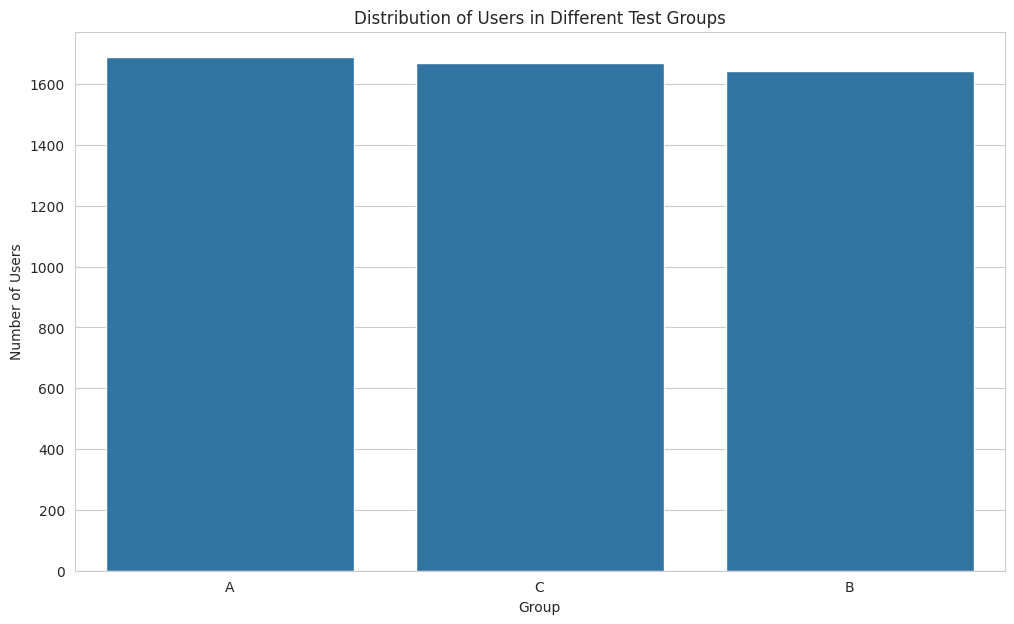


Group distribution (normalized):
group_letter
A    0.3376
C    0.3336
B    0.3288
Name: proportion, dtype: float64


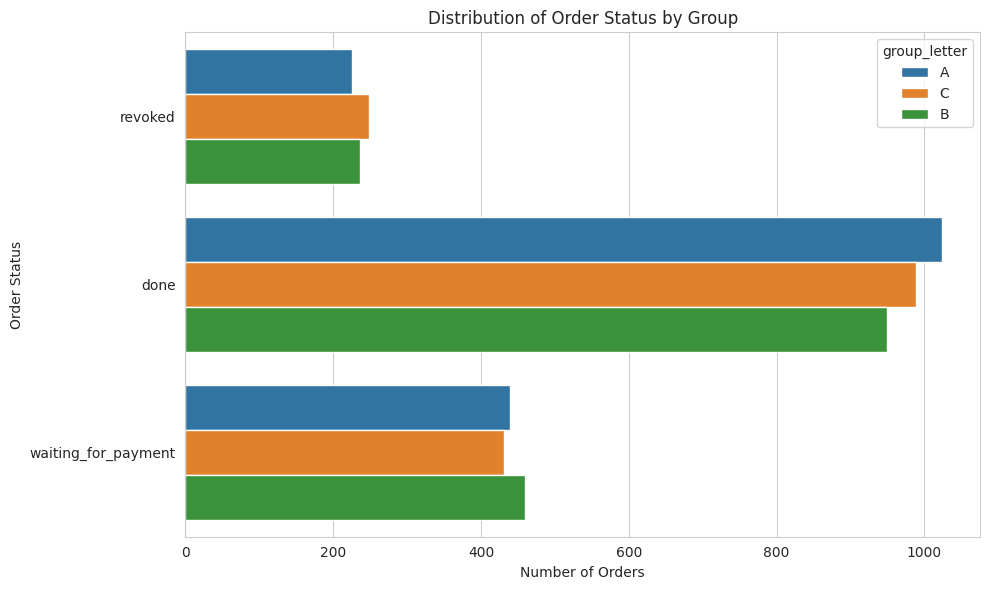


Order status distribution (normalized overall):
order_status
done                   0.5922
waiting_for_payment    0.2658
revoked                0.1420
Name: proportion, dtype: float64


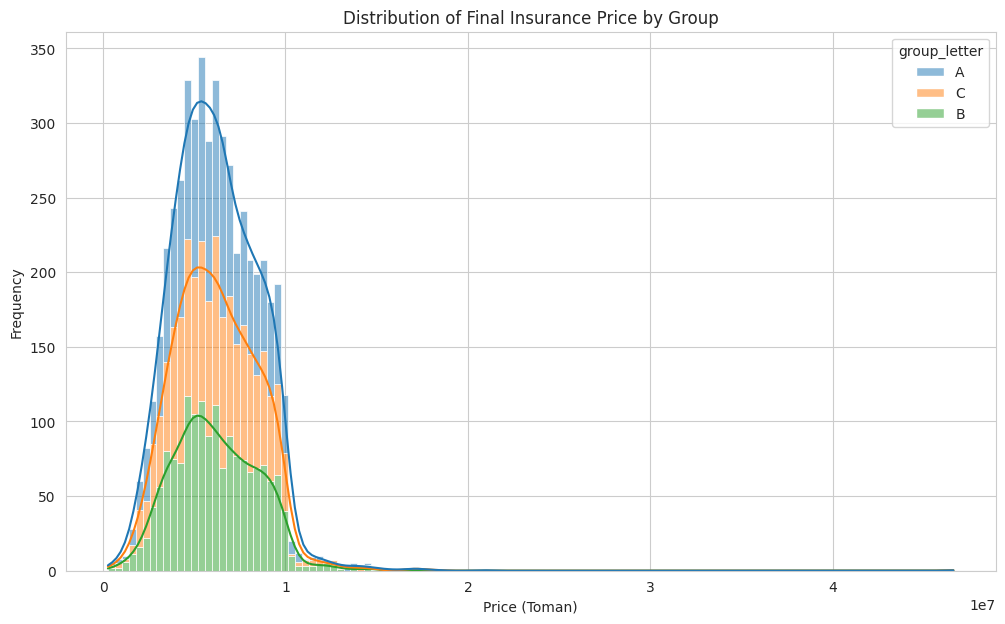

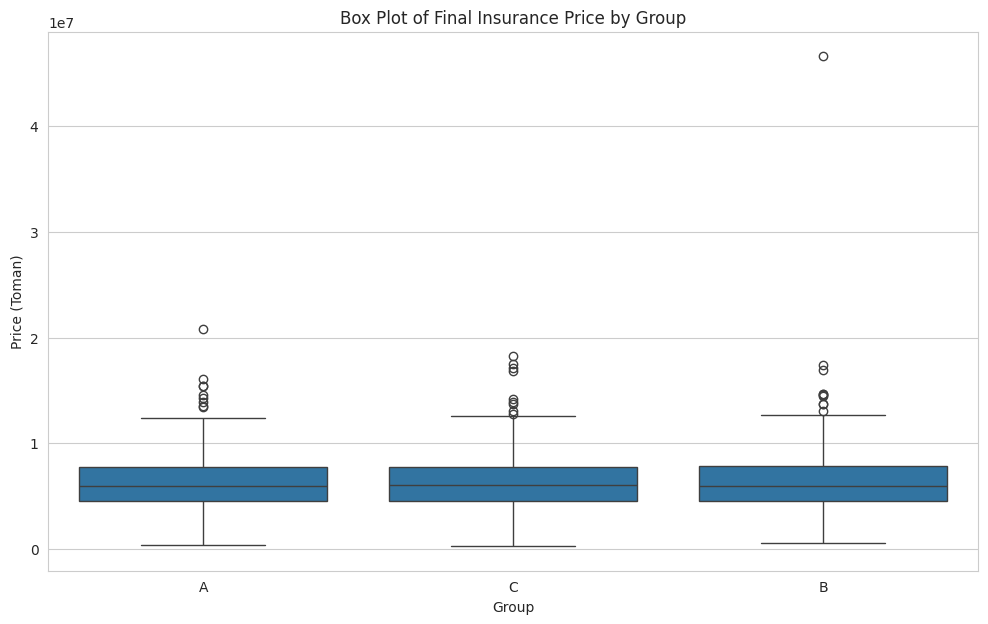


Distribution of Insurance Type:
type
vehicle_body_insurance    5000
Name: count, dtype: int64


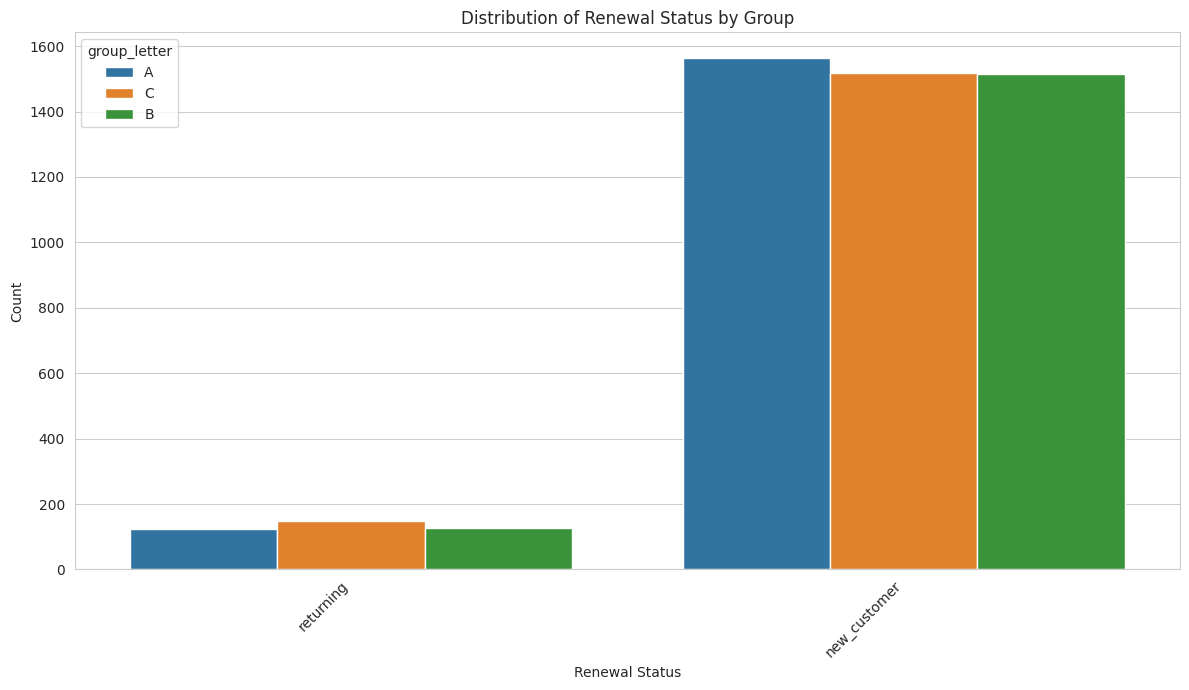

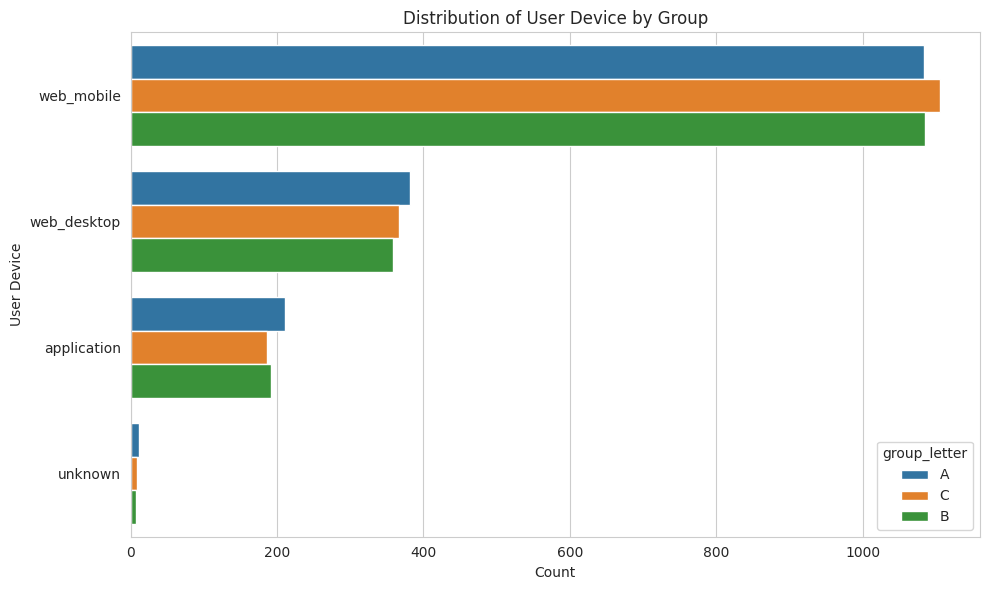

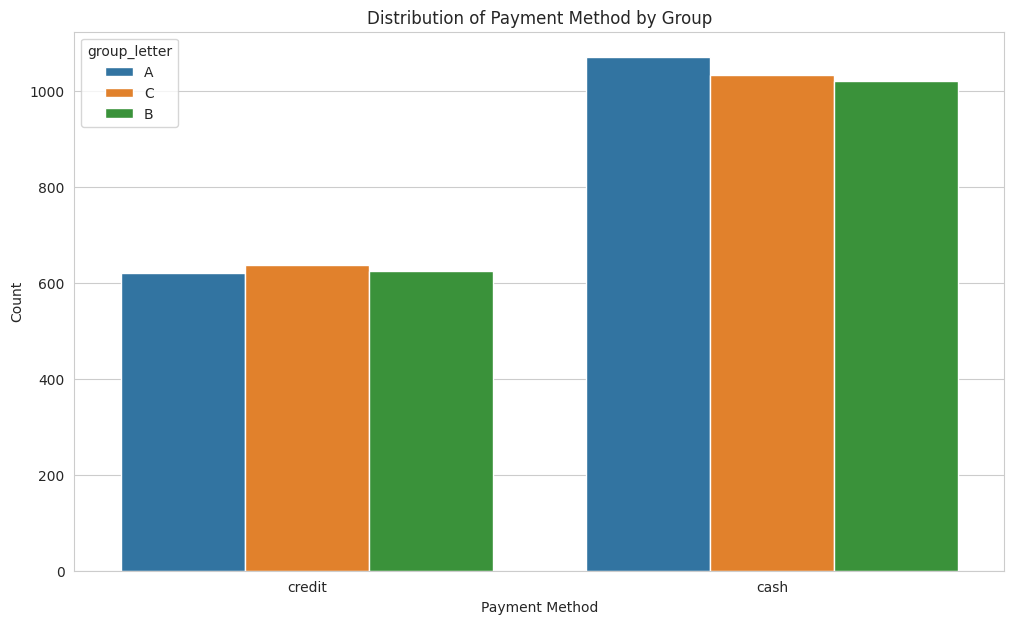

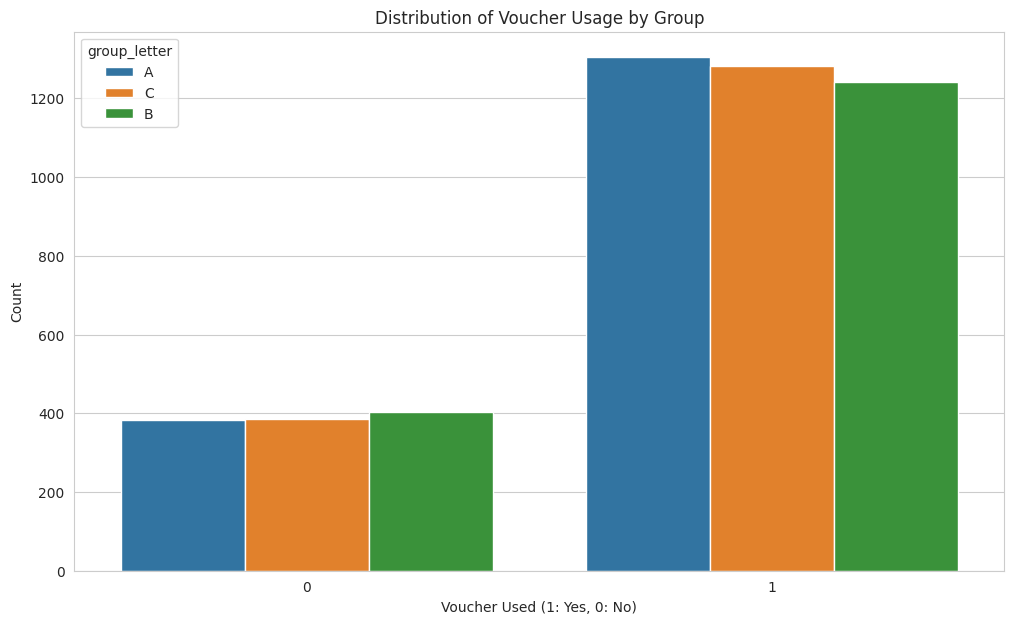

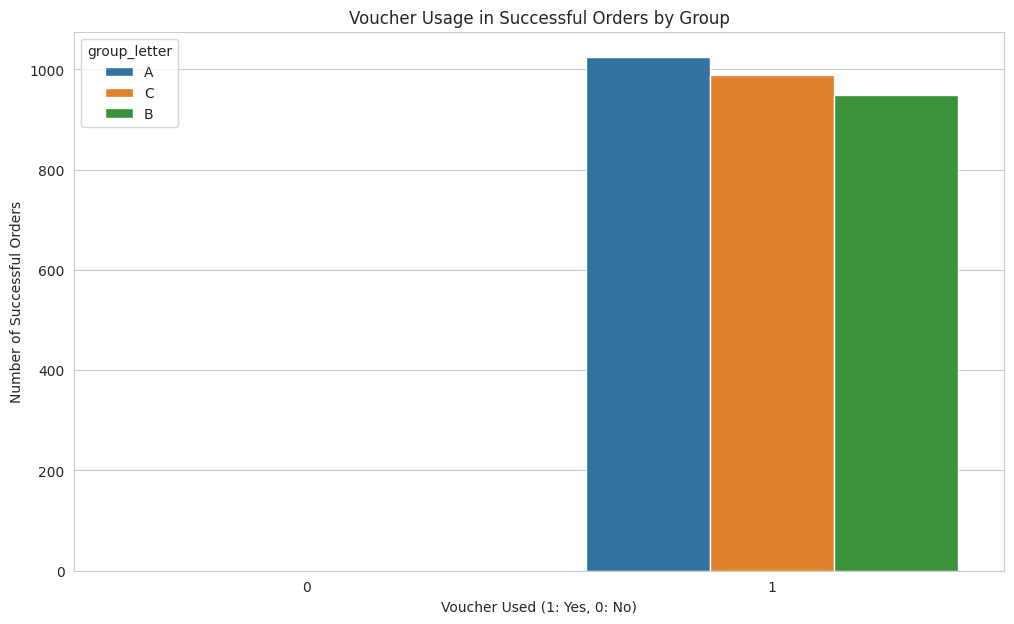

--------------------------------------------------
EDA plots generated and saved in: /home/shared/Atefeh/tn_refactor_log/az/ab_test_analysis_output_v3


In [ ]:


# --- Stage 2: Exploratory Data Analysis (EDA) - Task 1 (Continued) ---
print("\n--- Stage 2: Exploratory Data Analysis (EDA) ---")

if 'df' not in globals():
    print("DataFrame 'df' not found. Please run Stage 1 (loading and cleaning) first.")
    exit()

print("\nDescriptive statistics for numerical columns:")
print(df.describe())

print("\nDescriptive statistics for categorical columns:")
print(df.describe(include=['object']))

# Order for plots based on actual operation cost: A (0), C (40k), B (80k)
group_order = ['A', 'C', 'B']

# Distribution of groups (already verified, but good for visual consistency)
plt.figure()
sns.countplot(data=df, x='group_letter', order=group_order)
plt.title('Distribution of Users in Different Test Groups')
plt.xlabel('Group')
plt.ylabel('Number of Users')
plt.savefig(os.path.join(output_dir, "01_group_distribution.png"))
plt.show()
print("\nGroup distribution (normalized):")
print(df['group_letter'].value_counts(normalize=True).reindex(group_order))

# Distribution of order_status
plt.figure(figsize=(10,6)) # Adjusted for better readability
sns.countplot(data=df, y='order_status', hue='group_letter', hue_order=group_order)
plt.title('Distribution of Order Status by Group')
plt.xlabel('Number of Orders')
plt.ylabel('Order Status')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "02_order_status_distribution.png"))
plt.show()
print("\nOrder status distribution (normalized overall):")
print(df['order_status'].value_counts(normalize=True))

# Distribution of price
plt.figure()
sns.histplot(data=df, x='price', hue='group_letter', kde=True, hue_order=group_order, multiple="stack")
plt.title('Distribution of Final Insurance Price by Group')
plt.xlabel('Price (Toman)')
plt.ylabel('Frequency')
plt.savefig(os.path.join(output_dir, "03_price_distribution_hist.png"))
plt.show()

plt.figure()
sns.boxplot(data=df, x='group_letter', y='price', order=group_order)
plt.title('Box Plot of Final Insurance Price by Group')
plt.xlabel('Group')
plt.ylabel('Price (Toman)')
plt.savefig(os.path.join(output_dir, "04_price_distribution_boxplot.png"))
plt.show()

# Distribution of insurance type (type)
print("\nDistribution of Insurance Type:")
print(df['type'].value_counts())

# Distribution of renewal_status
plt.figure()
sns.countplot(data=df, x='renewal_status', hue='group_letter', hue_order=group_order)
plt.title('Distribution of Renewal Status by Group')
plt.xlabel('Renewal Status')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "05_renewal_status_distribution.png"))
plt.show()

# Distribution of user_device
plt.figure(figsize=(10,6)) # Adjusted
sns.countplot(data=df, y='user_device', hue='group_letter', hue_order=group_order)
plt.title('Distribution of User Device by Group')
plt.xlabel('Count')
plt.ylabel('User Device')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "06_user_device_distribution.png"))
plt.show()

# Distribution of payment_method
plt.figure()
sns.countplot(data=df, x='payment_method', hue='group_letter', hue_order=group_order)
plt.title('Distribution of Payment Method by Group')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, "07_payment_method_distribution.png"))
plt.show()

# Distribution of voucher usage
plt.figure()
sns.countplot(data=df, x='voucher', hue='group_letter', hue_order=group_order)
plt.title('Distribution of Voucher Usage by Group')
plt.xlabel('Voucher Used (1: Yes, 0: No)')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, "08_voucher_usage_distribution.png"))
plt.show()

# Voucher usage for successful orders
plt.figure()
# Ensure 'done' status exists, otherwise filter might result in empty df
successful_orders_df = df[df['order_status']=='done']
if not successful_orders_df.empty:
    sns.countplot(data=successful_orders_df, x='voucher', hue='group_letter', hue_order=group_order)
    plt.title('Voucher Usage in Successful Orders by Group')
    plt.xlabel('Voucher Used (1: Yes, 0: No)')
    plt.ylabel('Number of Successful Orders')
    plt.savefig(os.path.join(output_dir, "09_voucher_usage_successful_orders.png"))
    plt.show()
else:
    print("No successful orders ('done') found to plot voucher usage for successful orders.")

print("-" * 50)
print("EDA plots generated and saved in:", output_dir)


--- Stage 3 & 4: Calculating Metrics, Statistical Testing, and Visualization ---

Summary of A/B Test Results:
              Total Users  Successful Purchases  Conversion Rate (CR)  \
group_letter                                                            
A                    1688                  1024              0.606635   
C                    1668                   988              0.592326   
B                    1644                   949              0.577251   

              Average Order Value (AOV)  Total Revenue  \
group_letter                                             
A                          6.130148e+06   6.277271e+09   
C                          6.141403e+06   6.067706e+09   
B                          6.140145e+06   5.826997e+09   

              Revenue Per User (RPU)  Total Operational Fee Collected  
group_letter                                                           
A                       3.718763e+06                                0  
C              

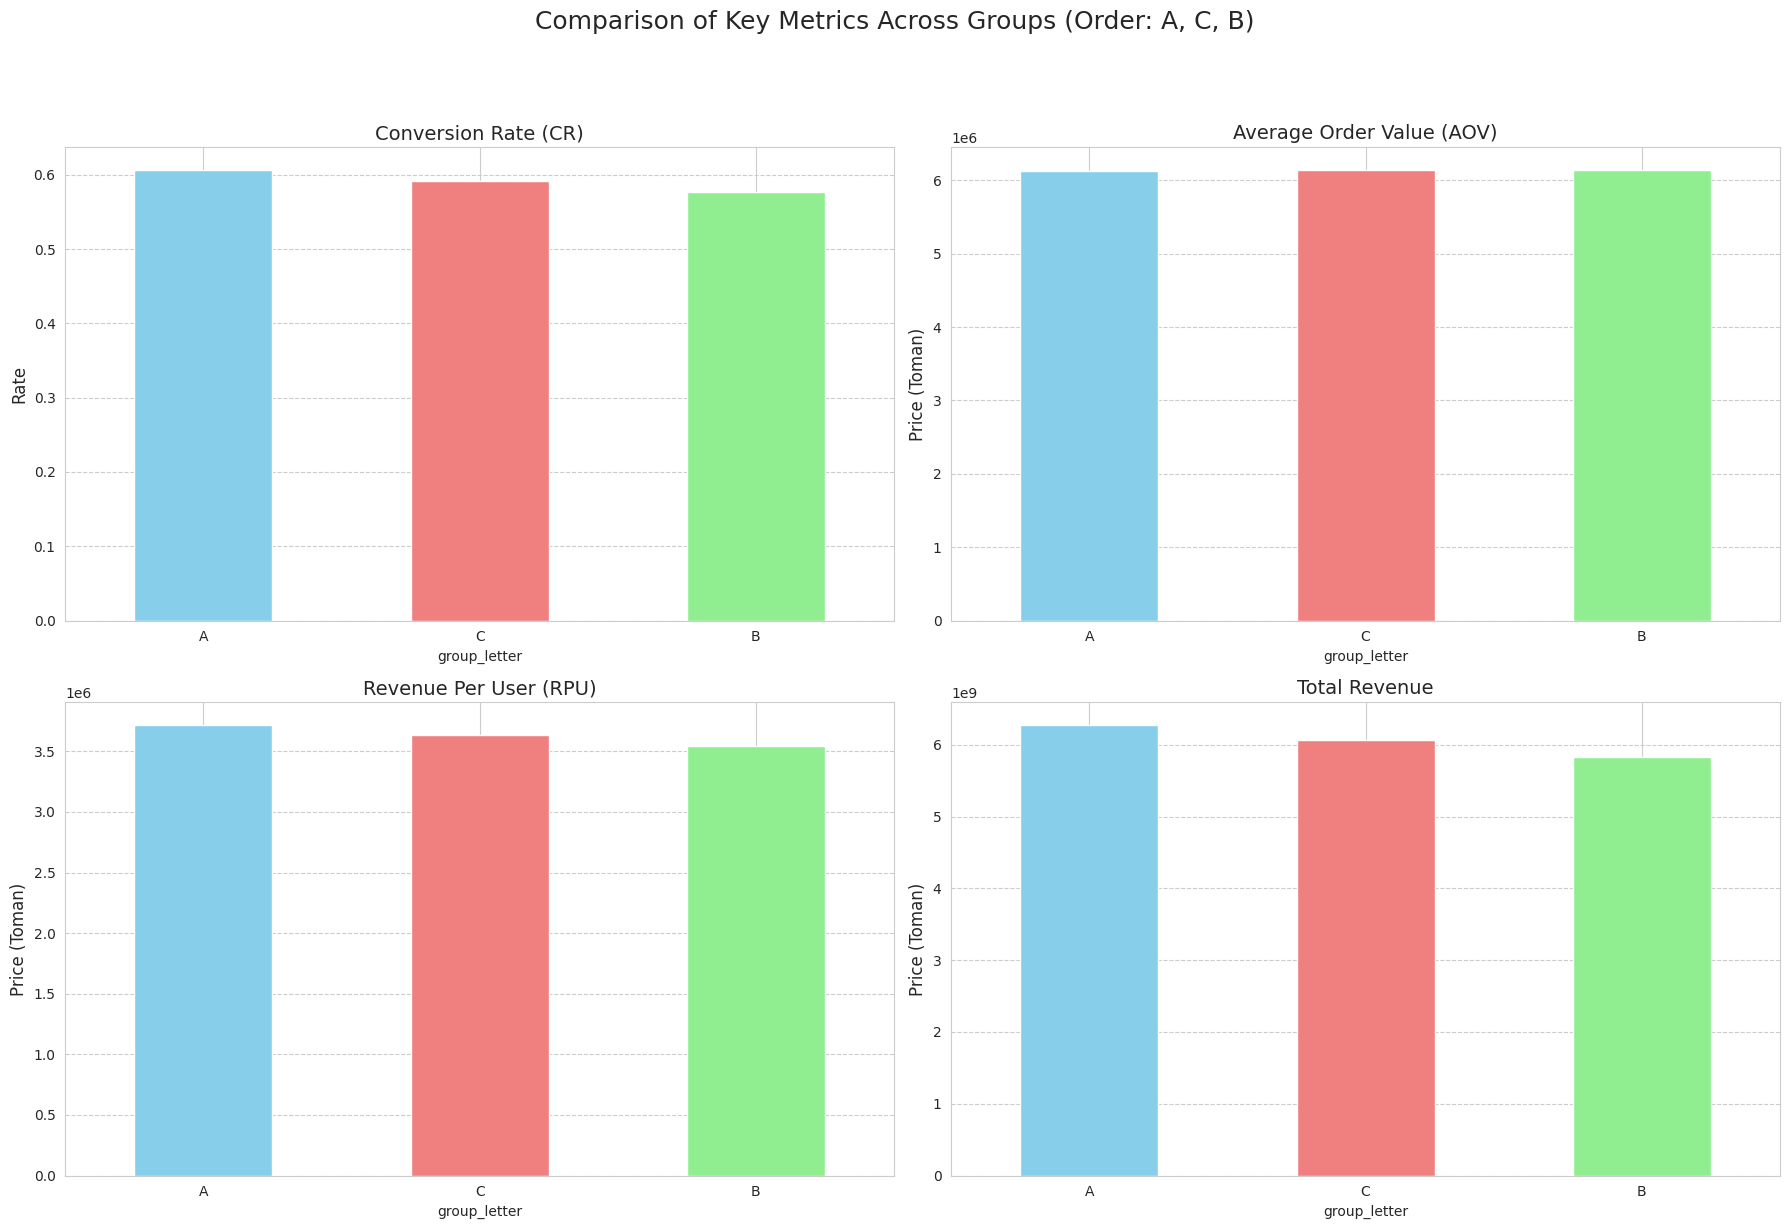


--- CR Analysis by Renewal Status ---
renewal_status  new_customer  returning
group_letter                           
A                   0.588235   0.838710
C                   0.579987   0.718121
B                   0.563325   0.742188


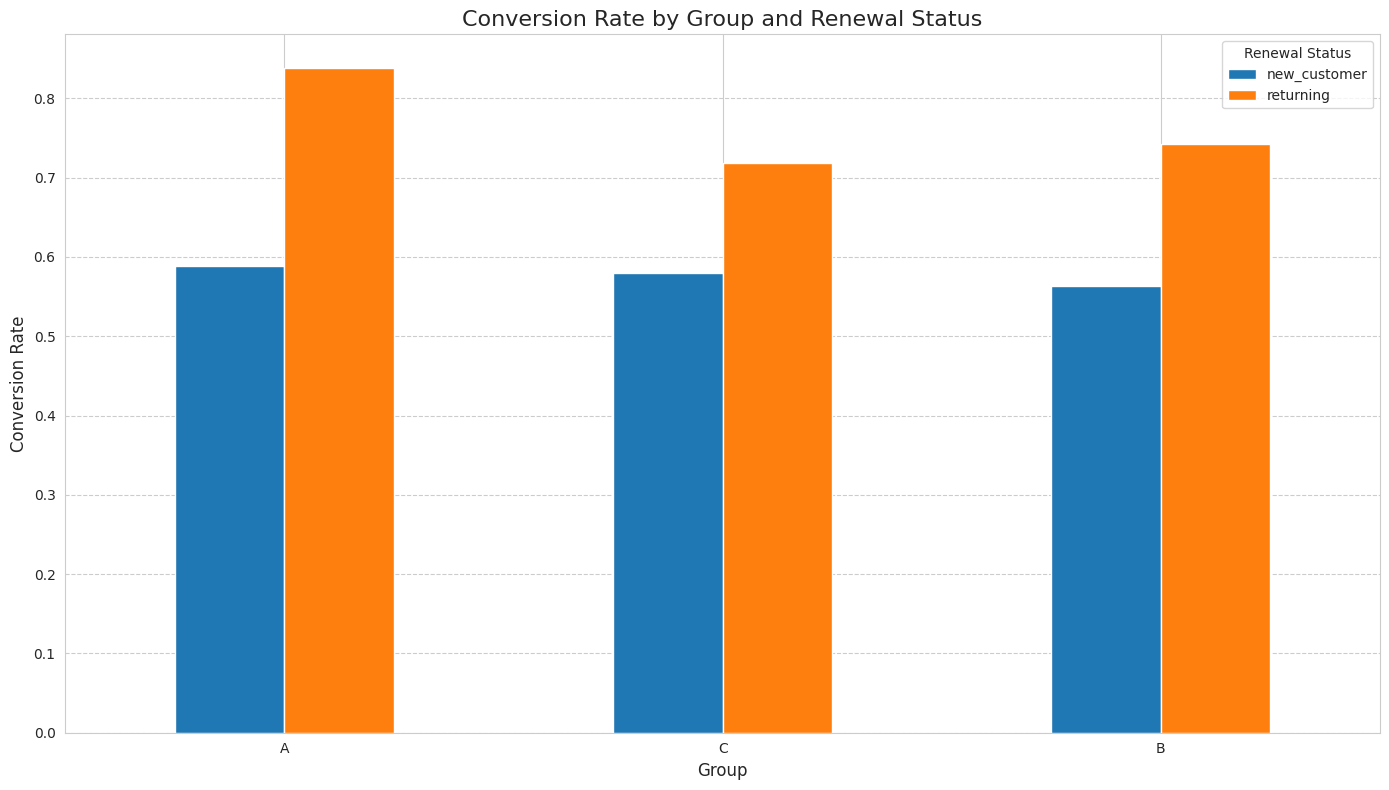


--- AOV Analysis by Renewal Status ---
renewal_status  new_customer     returning
group_letter                              
A               6.181741e+06  5.673741e+06
C               6.214371e+06  5.540607e+06
B               6.171216e+06  5.860836e+06


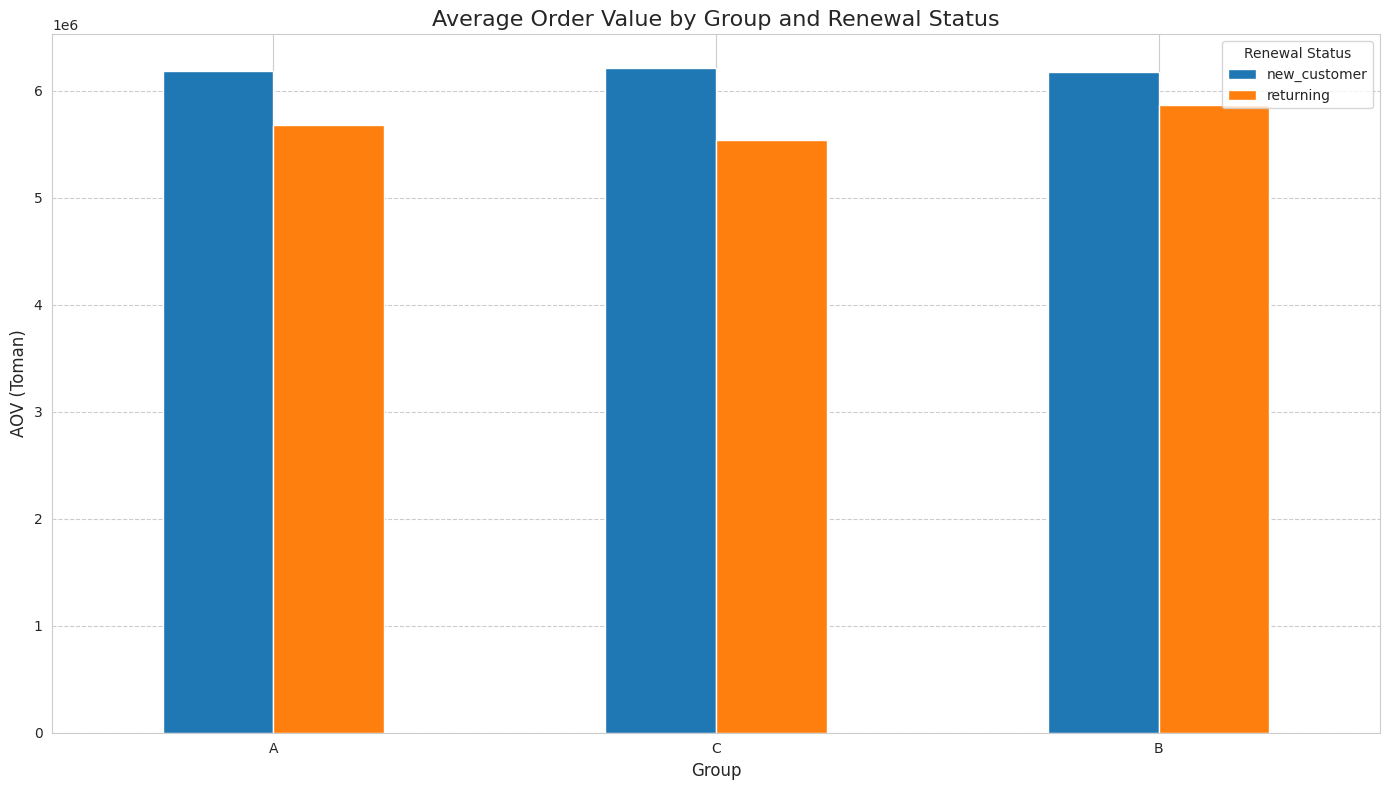

--------------------------------------------------
Metrics calculation and statistical testing complete.


In [4]:

# If not, you need to re-run the cleaned Stage 1 code first.
if 'df' not in globals():
    print("DataFrame 'df' not found. Please run Stage 1 (loading and cleaning) first.")
    # Re-run Stage 1 logic here if needed for a standalone script
    try:
        # Define the full path to the CSV file
        base_path = '/home/shared/Atefeh/tn_refactor_log/az/'
        output_dir = os.path.join(base_path, "ab_test_analysis_output_v3")
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        csv_file_path = os.path.join(base_path, "data.csv") # Make sure this is correct
        df_original = pd.read_csv(csv_file_path)
        df = df_original.copy()
        print(f"Dataset re-loaded successfully from: {csv_file_path} for Stage 3&4")

        if 'group' in df.columns:
            def parse_group_json(json_str):
                try:
                    data = json.loads(json_str)
                    return pd.Series([data['value']['group'], data['value']['operation_cost']])
                except: return pd.Series([None, None])
            df[['group_letter', 'operation_cost']] = df['group'].apply(parse_group_json)
            df.drop('group', axis=1, inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        df.dropna(subset=['price'], inplace=True)
        df['user_device'].fillna('unknown', inplace=True)
        df['renewal_status'].fillna('unknown', inplace=True)
        print("DataFrame 'df' re-loaded and cleaned for Stage 3&4.")
    except Exception as e:
        print(f"Error re-loading/cleaning df: {e}")
        exit()


print("\n--- Stage 3 & 4: Calculating Metrics, Statistical Testing, and Visualization ---")

# Order for consistency in results and plots
group_order = ['A', 'C', 'B'] # Based on 0, 40k, 80k operation cost

# Calculate total users per group
total_users_per_group = df['group_letter'].value_counts().reindex(group_order).fillna(0)

# Filter for successful orders
successful_orders = df[df['order_status'] == 'done'].copy()

# 1. Conversion Rate (CR)
conversions_per_group = successful_orders['group_letter'].value_counts().reindex(group_order).fillna(0)
conversion_rate = (conversions_per_group / total_users_per_group).fillna(0)

# 2. Average Order Value (AOV) - based on final price paid
aov = successful_orders.groupby('group_letter')['price'].mean().reindex(group_order).fillna(0)

# 3. Total Revenue
total_revenue = successful_orders.groupby('group_letter')['price'].sum().reindex(group_order).fillna(0)

# 4. Revenue Per User (RPU)
rpu = (total_revenue / total_users_per_group).fillna(0)

# 5. Total Operational Fee Collected
total_operational_fee = successful_orders.groupby('group_letter')['operation_cost'].sum().reindex(group_order).fillna(0)

# Create a summary DataFrame for results
summary_df = pd.DataFrame({
    'Total Users': total_users_per_group,
    'Successful Purchases': conversions_per_group,
    'Conversion Rate (CR)': conversion_rate,
    'Average Order Value (AOV)': aov,
    'Total Revenue': total_revenue,
    'Revenue Per User (RPU)': rpu,
    'Total Operational Fee Collected': total_operational_fee
})
summary_df = summary_df[['Total Users', 'Successful Purchases', 'Conversion Rate (CR)',
                         'Average Order Value (AOV)', 'Total Revenue', 'Revenue Per User (RPU)',
                         'Total Operational Fee Collected']] # Ensure column order

print("\nSummary of A/B Test Results:")
print(summary_df)

# --- Statistical Significance Testing ---
print("\n--- Statistical Significance Testing ---")
alpha = 0.05 # Significance level

# 1. Conversion Rate (CR) - using proportions_ztest
print("\nConversion Rate (CR) Comparisons:")
for i in range(len(group_order)):
    for j in range(i + 1, len(group_order)):
        group1_letter = group_order[i]
        group2_letter = group_order[j]

        count = [conversions_per_group.get(group1_letter, 0), conversions_per_group.get(group2_letter, 0)]
        nobs = [total_users_per_group.get(group1_letter, 0), total_users_per_group.get(group2_letter, 0)]

        if nobs[0] == 0 or nobs[1] == 0:
            print(f"Skipping CR comparison between {group1_letter} and {group2_letter} due to zero observations in one group.")
            continue

        z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
        print(f"CR Comparison between {group1_letter} and {group2_letter}: Z-stat={z_stat:.3f}, P-value={p_value:.4f}", end="")
        if p_value < alpha:
            print(f" (Significant at alpha={alpha})")
        else:
            print(f" (Not significant at alpha={alpha})")

# 2. Average Order Value (AOV) - using Mann-Whitney U
print("\nAverage Order Value (AOV) Comparisons (Mann-Whitney U):")
aov_data = {}
for letter in group_order:
    aov_data[letter] = successful_orders[successful_orders['group_letter'] == letter]['price']

for i in range(len(group_order)):
    for j in range(i + 1, len(group_order)):
        group1_letter = group_order[i]
        group2_letter = group_order[j]

        data1 = aov_data[group1_letter]
        data2 = aov_data[group2_letter]

        if len(data1) < 1 or len(data2) < 1 :
            print(f"Skipping AOV comparison between {group1_letter} and {group2_letter} due to insufficient data.")
            continue
        # Perform test only if both groups have data for AOV
        if not data1.empty and not data2.empty:
            try:
                u_stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
                print(f"AOV Comparison between {group1_letter} and {group2_letter}: U-stat={u_stat:.0f}, P-value={p_value:.4f}", end="")
                if p_value < alpha:
                    print(f" (Significant at alpha={alpha})")
                else:
                    print(f" (Not significant at alpha={alpha})")
            except ValueError as e: # Handles cases like all values being identical
                print(f"Could not compare AOV for {group1_letter} and {group2_letter}: {e}")
        else:
            print(f"Skipping AOV comparison between {group1_letter} and {group2_letter} due to one or both groups having no successful orders.")


# Visualizing Key Metrics
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Comparison of Key Metrics Across Groups (Order: A, C, B)', fontsize=18, y=1.02)

summary_df['Conversion Rate (CR)'].plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0,0].set_title('Conversion Rate (CR)', fontsize=14)
axes[0,0].set_ylabel('Rate', fontsize=12)
axes[0,0].tick_params(axis='x', rotation=0, labelsize=10)
axes[0,0].grid(axis='y', linestyle='--')

summary_df['Average Order Value (AOV)'].plot(kind='bar', ax=axes[0,1], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0,1].set_title('Average Order Value (AOV)', fontsize=14)
axes[0,1].set_ylabel('Price (Toman)', fontsize=12)
axes[0,1].tick_params(axis='x', rotation=0, labelsize=10)
axes[0,1].grid(axis='y', linestyle='--')

summary_df['Revenue Per User (RPU)'].plot(kind='bar', ax=axes[1,0], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1,0].set_title('Revenue Per User (RPU)', fontsize=14)
axes[1,0].set_ylabel('Price (Toman)', fontsize=12)
axes[1,0].tick_params(axis='x', rotation=0, labelsize=10)
axes[1,0].grid(axis='y', linestyle='--')

summary_df['Total Revenue'].plot(kind='bar', ax=axes[1,1], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1,1].set_title('Total Revenue', fontsize=14)
axes[1,1].set_ylabel('Price (Toman)', fontsize=12)
axes[1,1].tick_params(axis='x', rotation=0, labelsize=10)
axes[1,1].grid(axis='y', linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(os.path.join(output_dir, "10_key_metrics_comparison.png"))
plt.show()


# Analysis by existing features (Example: renewal_status)
print("\n--- CR Analysis by Renewal Status ---")
cr_by_renewal = df.groupby(['group_letter', 'renewal_status'])['order_status'].apply(lambda x: (x == 'done').mean()).unstack().reindex(group_order)
print(cr_by_renewal)

ax_cr_renewal = cr_by_renewal.plot(kind='bar', figsize=(14,8))
ax_cr_renewal.set_title('Conversion Rate by Group and Renewal Status', fontsize=16)
ax_cr_renewal.set_ylabel('Conversion Rate', fontsize=12)
ax_cr_renewal.set_xlabel('Group', fontsize=12)
ax_cr_renewal.tick_params(axis='x', rotation=0, labelsize=10)
ax_cr_renewal.tick_params(axis='y', labelsize=10)
ax_cr_renewal.legend(title='Renewal Status', fontsize=10)
ax_cr_renewal.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "11_cr_by_renewal_status.png"))
plt.show()

print("\n--- AOV Analysis by Renewal Status ---")
# Ensure successful_orders is not empty
if not successful_orders.empty:
    aov_by_renewal = successful_orders.groupby(['group_letter', 'renewal_status'])['price'].mean().unstack().reindex(group_order)
    print(aov_by_renewal)

    ax_aov_renewal = aov_by_renewal.plot(kind='bar', figsize=(14,8))
    ax_aov_renewal.set_title('Average Order Value by Group and Renewal Status', fontsize=16)
    ax_aov_renewal.set_ylabel('AOV (Toman)', fontsize=12)
    ax_aov_renewal.set_xlabel('Group', fontsize=12)
    ax_aov_renewal.tick_params(axis='x', rotation=0, labelsize=10)
    ax_aov_renewal.tick_params(axis='y', labelsize=10)
    ax_aov_renewal.legend(title='Renewal Status', fontsize=10)
    ax_aov_renewal.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "12_aov_by_renewal_status.png"))
    plt.show()
else:
    print("No successful orders to analyze AOV by renewal status.")

print("-" * 50)
print("Metrics calculation and statistical testing complete.")